# Part 1

For this first part, we want to cover:
    
- Querry, retrieve and download satellite images directly with Python in Jupyter notebook.
- Read and Write Raster images in Python.
- Create RGB and NDVI images from Sentinel 2 Bands

# Install libraries

In [2]:
#!pip install sentinelsat

In [ ]:
#!pip install folium

In [ ]:
#!pip install shapely

# Import required libraries

In [1]:
import sentinelsat
import geopandas as gpd
from osgeo import gdal
import georaster
import rasterio
import rasterio as rio
from rasterio import mask as msk
from rasterio import plot
from rasterio.plot import show
import folium 
import shapely
from shapely.geometry import MultiPolygon, Polygon
from sentinelsat.sentinel import SentinelAPI, read_geojson, geojson_to_wkt

import zipfile
from PIL import Image
import matplotlib.pyplot as plt

import random

%matplotlib inline

# Accessing data

 we need to register a username in [Copernicus Open Access Hub](https://scihub.copernicus.eu/dhus/#/home) and note down your username and password and paste them here inside the code.

In [2]:
from sentinelsat import SentinelAPI

user = "Marcinclair" 
password = "Marcinclair" 
api = SentinelAPI(user, password, "https://scihub.copernicus.eu/dhus")

# Display the shapefile data as a map

In [183]:
def displayMap(file, latitude, longitude):
    
    # latitude and logitude range for Malawi
    range_latitude_Malw = [-15, -11]
    range_longitude_Malw = [33, 35]
    
    # latitude and logitude range for Mozambique
    range_latitude_Moz = [-26, -18]
    range_longitude_Moz = [32, 36]
    
    Country_Name = input("Enter the name of your choosen country : Malawi or Mozambique\n")
    if Country_Name == "Malawi":
        
        if (latitude >= range_latitude_Malw[0] and latitude <= range_latitude_Malw[1]):
            latitude = latitude 
        else:
            raise ValueError("Your latitude don't match! Please try again.")
            
        if (longitude >= range_longitude_Malw[0] and longitude <= range_longitude_Malw[1]):
            longitude = longitude 
        else:
            raise ValueError("Your latitude don't match! Please try again.")
            
    if Country_Name == "Mozambique":
        
        if (latitude >= range_latitude_Moz[0] and latitude <= range_latitude_Moz[1]):
            latitude = latitude 
        else:
            raise ValueError("Your latitude don't match! Please try again.")
            
        if (longitude >= range_longitude_Moz[0] and longitude <= range_longitude_Moz[1]):
            longitude = longitude 
        else:
            raise ValueError("Your latitude don't match! Please try again.")
        
    MAP = folium.Map([latitude, longitude], zoom_start=5)
    folium.GeoJson(file).add_to(MAP)
    return MAP

### Display for Mozambique 

In [186]:
shapefile_Mozam_data1 = gpd.read_file("ShapeMozambique/MOZ_adm1.shp")

bounds = gpd.read_file("C:/Users/engelbert/Downloads/Ishango/Notebook/mapMozambique.geojson")

latitudeMozan = -18.665695
longitudeMozan = 35.529562



displayMap(bounds, latitudeMozan, longitudeMozan)

Enter the name of your choosen country : Malawi or Mozambique
Mozambique


### Display for Malawi

In [5]:
# shapefile_Malw_data1 = gpd.read_file("ShapeMalawi/MWI_adm1.shp")
# latitudeMalw = -13.9621
# longitudeMalw = 33.7937
# [-13.2512161, 34.3015278]    # [-15.786111, 35.005833]

# displayMap(shapefile_Malw_data1, latitudeMalw, longitudeMalw)

In [6]:
# footprint = None
# for i in shapefile_Mozam_data1['geometry']:
#     footprint = i

For geojson file, specify a geometry here: http://geojson.io/

In [92]:
# search by polygon

bounds_data = "C:/Users/engelbert/Downloads/Ishango/Notebook/mapMozambique.geojson"

footprint = geojson_to_wkt(read_geojson(bounds_data))

print (footprint)

GEOMETRYCOLLECTION(POLYGON((35.8594 -15.8557,35.5518 -16.2991,35.3101 -16.7204,35.2661 -17.1828,34.7607 -16.7835,34.1016 -15.9191,34.3652 -15.1570,33.2446 -14.5198,31.6846 -14.6048,30.4761 -15.1994,30.5640 -15.8134,31.7065 -16.0880,33.0469 -16.6783,33.1128 -18.2502,33.0029 -19.9527,32.6294 -21.5348,34.2773 -21.1255,34.6729 -19.8701,35.4199 -19.0413,36.5186 -18.1667,38.5400 -16.6993,39.8364 -14.9448,39.9683 -12.6403,39.1772 -11.2862,37.2656 -11.7598,35.6836 -12.5117,35.3979 -13.9661,35.9033 -14.3283,35.8594 -15.8557)))


# Searching products

In [93]:
products = api.query(footprint,
                     date = ('20200901', '20210225'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,20)
                    )

Querying products:   6%|6         | 100/1569 [00:00<?, ?product/s]

In [94]:
print(f"The number of products are : {len(products)}")

The number of products are : 1569


# Convert the result into pandas

In [81]:
# products_gdf = api.to_geodataframe(products)
# products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
# products_gdf_sorted

In [95]:
products_gdf = api.to_geodataframe(products)
products_gdf.head(2)

,title,link,link_alternative,link_icon,summary,ondemand,ingestiondate,beginposition,endposition,generationdate,...,processingbaseline,processinglevel,producttype,platformname,size,datastripidentifier,granuleidentifier,level1cpdiidentifier,uuid,geometry
bf5929d3-3226-4cd8-bdec-672765663409,S2A_MSIL2A_20210224T072901_N0214_R049_T37KCA_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2021-02-24T07:29:01.024Z, Instrument: MS...",false,2021-02-24 15:11:28.446,2021-02-24 07:29:01.024,2021-02-24 07:29:01.024,2021-02-24 10:07:32,...,02.14,Level-2A,S2MSI2A,Sentinel-2,429.79 MB,S2A_OPER_MSI_L2A_DS_VGS1_20210224T100732_S2021...,S2A_OPER_MSI_L2A_TL_VGS1_20210224T100732_A0296...,S2A_OPER_MSI_L1C_TL_VGS1_20210224T093541_A0296...,bf5929d3-3226-4cd8-bdec-672765663409,"MULTIPOLYGON (((37.36598 -18.16946, 37.37446 -..."
d3efa72a-648b-4416-ba24-1696e6b91410,S2A_MSIL2A_20210224T072901_N0214_R049_T36KXC_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2021-02-24T07:29:01.024Z, Instrument: MS...",false,2021-02-24 15:03:43.589,2021-02-24 07:29:01.024,2021-02-24 07:29:01.024,2021-02-24 10:07:32,...,02.14,Level-2A,S2MSI2A,Sentinel-2,1.04 GB,S2A_OPER_MSI_L2A_DS_VGS1_20210224T100732_S2021...,S2A_OPER_MSI_L2A_TL_VGS1_20210224T100732_A0296...,S2A_OPER_MSI_L1C_TL_VGS1_20210224T093541_A0296...,d3efa72a-648b-4416-ba24-1696e6b91410,"MULTIPOLYGON (((33.96143 -20.88537, 35.01672 -..."


We can use plot method with sentinelsat to see where the image boundaries lie.

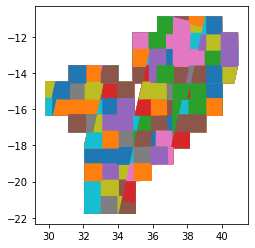

In [96]:
areas = api.to_geodataframe(products)
areas.plot(column='uuid', cmap=None);

In [97]:
# areas = api.to_geodataframe(products)
# areas.plot(column='uuid', cmap=None, legend=True);

C:\Users\ENGELB~1\AppData\Local\Temp/ipykernel_9928/3607753679.py:4: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  areas.apply(lambda x: ax.annotate(s=x.uuid, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);


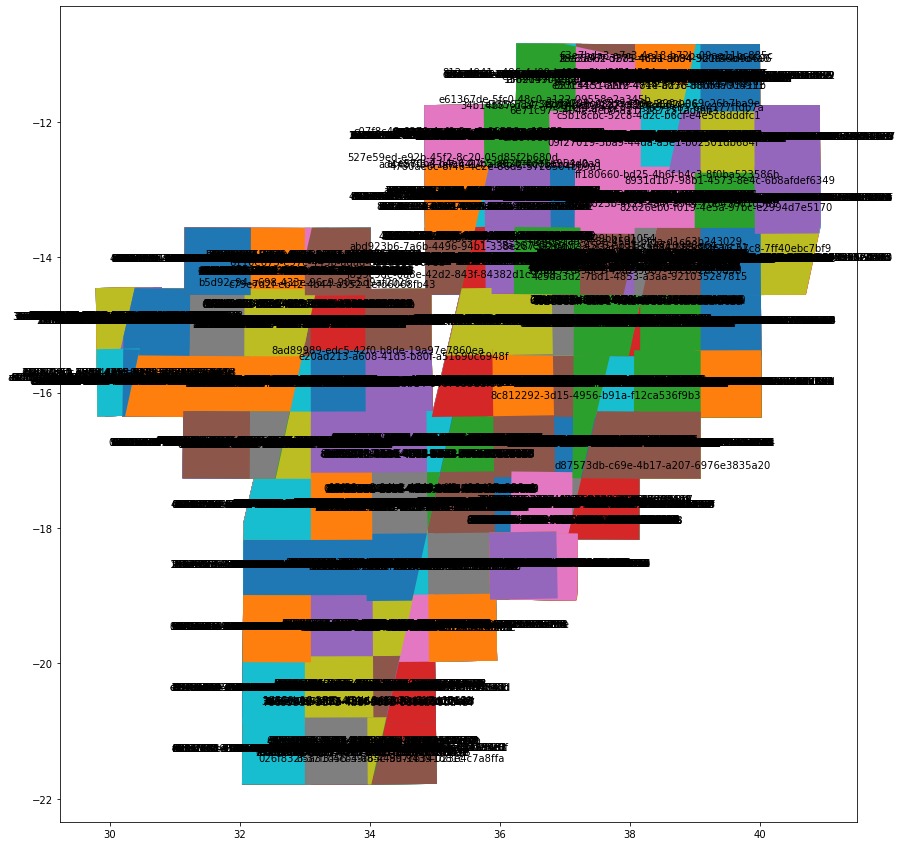

In [98]:
# Label the polygon

ax = areas.plot(column='uuid', cmap=None, figsize=(15, 15))
areas.apply(lambda x: ax.annotate(s=x.uuid, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);

I think it is difficult to found that intersection over all those products when we have a lot of products. Now what I'm trying to do is to check if the product is available online or not. In the case where the products is available online, I can choose one of them.

In [99]:
# # Display the product ID

# for i in range(len(areas.uuid)):
#     print(areas.uuid[i])
# print()
# print(type(areas.uuid[0]))

In [100]:
print(f"The number of products are : {len(products_gdf['uuid'])}")

The number of products are : 1569


In [101]:
a = api.get_product_odata(products_gdf['uuid'][1])

In [89]:
a

{'id': '09634c60-3b61-4217-83f8-812db827b51e',
 'title': 'S2A_MSIL2A_20210224T072901_N0214_R049_T36KWB_20210224T100732',
 'size': 423381252,
 'md5': '7c905eb0829c09b6e852c39625e9308c',
 'date': datetime.datetime(2021, 2, 24, 7, 29, 1, 24000),
 'footprint': 'POLYGON((33.59764059655036 -21.78985758908516,33.62469409128214 -21.684157260056665,33.66241575222387 -21.53640666934044,33.699912692374554 -21.388520643421863,33.737469245718664 -21.24065634097632,33.77493455579177 -21.092745392544654,33.81232375889758 -20.944870891307424,33.84964440877766 -20.797086985238877,34.05483160176843 -20.796456414334852,34.06193203129382 -21.788366104928123,33.59764059655036 -21.78985758908516))',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('09634c60-3b61-4217-83f8-812db827b51e')/$value",
 'Online': False,
 'Creation Date': datetime.datetime(2021, 2, 24, 15, 2, 54, 498000),
 'Ingestion Date': datetime.datetime(2021, 2, 24, 15, 2, 54, 498000),
 'quicklook_url': "https://scihub.copernicus.e

## Downloading data

In [102]:
# This function take as input a uuid of a product, 
# check if the products ID is available online,
# print he number of products ID available online,
# download the data for a random particular ID

def check_Download_Random_ProductID(products_gdf_uuid):
    
    cpt = 0
    lis_of_index_products_online = []
    
    # go over the number of products
    for i in range(len(products_gdf_uuid)):
        
        # get the ID products which is a dictionnary
        product_id = api.get_product_odata(products_gdf_uuid[i])
        
        # go over the keys and get the values
        for j in product_id.keys():
            if (j == 'Online' and product_id[j] == True):
                
                # put the index of product available online  in the list
                lis_of_index_products_online.append(i)
                    
                # print the index and ID of available product online
                print(f"For the index = {i} , the product with ID = {products_gdf_uuid[i]} is online")
            
                # count the number of product available online
                cpt += 1
    
    # print the list of the index available product online
    print()
    print(f"The list of the index available product online is : {lis_of_index_products_online}")
    print('----'*10)
    print()
    print(f"The number of products which is online are : {cpt}")
    
    # check if the list is empty
    if len(lis_of_index_products_online) == 0:
        
        raise ValueError("You can't proceed to the download now because any produc there is no product available online at the moment.")
    
    else:
        
        # Downloading for a particular ID randomly
        choice_index_product_random = random.choice(lis_of_index_products_online)
        api.download(products_gdf_uuid[choice_index_product_random])
                    
    

In [103]:
products_gdf_uuid = products_gdf.uuid 

check_Download_Random_ProductID(products_gdf_uuid)


The list of the index available product online is : []
----------------------------------------

The number of products which is online are : 0


ValueError: You can't proceed to the download now because you don't have any product available online at the moment.

We can realize that a few product are online.

In [ ]:
# # Downloading for all the products

# api.download_all(products) 

## Unzip data

In [63]:
path_to_zip = './S2A_MSIL2A_20210125T073201_N0214_R049_T37KCB_20210125T100129.zip'
path_to_extract_to = './'

with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
    zip_ref.extractall(path_to_extract_to)

# Create RGB Image

The true color of satellite images is often displayed in a combination of the red, green and blue bands. Let us first read the data with Rasterio and create an RGB image from Bands 4, 3, and 2.

Our sensor is capable of capturing for different multispectral bands including **red, green, blue** and **near-infrared (nir)** with resolution of 10 to 60 meters.

In [65]:
# Open Bands 4, 3 and 2 with Rasterio

"""
First, we open an empty RGB.tiff in Rasterio with the same parameters — i.e. width, height, CRS, etc..
— of Band 4 ( You can choose any of the three bands). Then we need to write those bands to the empty RGB image.
"""


path = 'C:/Users/engelbert/Downloads/Ishango/Notebook/S2A_MSIL2A_20210125T073201_N0214_R049_T37KCB_20210125T100129.SAFE/GRANULE/L2A_T37KCB_A029218_20210125T075032/IMG_DATA/R10m/'
band4 = rasterio.open(path+'T37KCB_20210125T073201_B04_10m.jp2')
band3 = rasterio.open(path+'T37KCB_20210125T073201_B03_10m.jp2')
band2 = rasterio.open(path+'T37KCB_20210125T073201_B02_10m.jp2')


# Create an RGB image 
with rio.open('RGB.tiff', 'w', driver='Gtiff', width=band4.width, height=band4.height, 
              count=3, crs=band4.crs, transform=band4.transform, dtype=band4.dtypes[0]) as rgb:
    rgb.write(band2.read(1),1) 
    rgb.write(band3.read(1),2) 
    rgb.write(band4.read(1),3) 
    rgb.close()

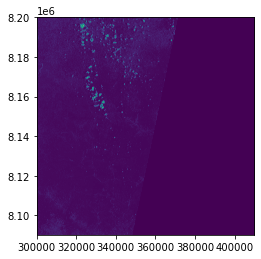

<AxesSubplot:>

In [66]:
show(band4)

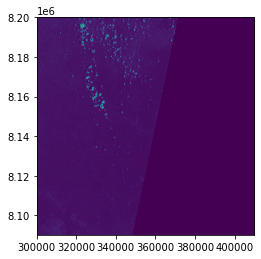

<AxesSubplot:>

In [67]:
show(band3)

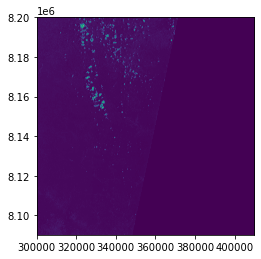

<AxesSubplot:>

In [68]:
show(band2)

In [69]:
# import bands as separate 1 band raster

path = 'C:/Users/engelbert/Downloads/Ishango/Notebook/S2A_MSIL2A_20210125T073201_N0214_R049_T37KCB_20210125T100129.SAFE/GRANULE/L2A_T37KCB_A029218_20210125T075032/IMG_DATA/R10m/'

band3 = rasterio.open(path+'T37KCB_20210125T073201_B03_10m.jp2', driver='JP2OpenJPEG') # green
band4 = rasterio.open(path+'T37KCB_20210125T073201_B04_10m.jp2', driver='JP2OpenJPEG') # red
band8 = rasterio.open(path+'T37KCB_20210125T073201_B08_10m.jp2', driver='JP2OpenJPEG') # nir

In [70]:
# number of raster bands

band8.count

1

In [71]:
# number of raster columns

band8.width

10980

In [72]:
# number of raster rows

band8.height

10980

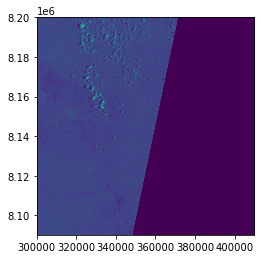

<AxesSubplot:>

In [73]:
# plot band 

plot.show(band8)

In [74]:
# type of raster byte

band8.dtypes[0]

'uint16'

In [75]:
# raster sytem of reference

band8.crs

CRS.from_epsg(32737)

In [76]:
# raster transform parameters

band8.transform

Affine(10.0, 0.0, 300000.0,
       0.0, -10.0, 8200000.0)

In [77]:
# raster values as matrix array

band8.read(1)

array([[2776, 2742, 2844, ...,    0,    0,    0],
       [2700, 2608, 2800, ...,    0,    0,    0],
       [2534, 2712, 2768, ...,    0,    0,    0],
       ...,
       [2482, 2260, 2280, ...,    0,    0,    0],
       [2806, 2522, 2358, ...,    0,    0,    0],
       [2634, 2514, 2294, ...,    0,    0,    0]], dtype=uint16)

In [78]:
# # multiple band representation

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
# plot.show(band2, ax=ax1, cmap='Blues')
# plot.show(band3, ax=ax2, cmap='Greens')
# plot.show(band4, ax=ax3, cmap='Reds')
# fig.tight_layout()

In [80]:
# export true color image

trueColor = rasterio.open('C:/Users/engelbert/Downloads/Ishango/Notebook/SentinelColor/SentinelTrueColor.tiff','w',driver='Gtiff',
                         width=band4.width, height=band4.height,
                         count=3,
                         crs=band4.crs,
                         transform=band4.transform,
                         dtype=band4.dtypes[0]
                         )
trueColor.write(band2.read(1),3) #blue
trueColor.write(band3.read(1),2) #green
trueColor.write(band4.read(1),1) #red
trueColor.close()

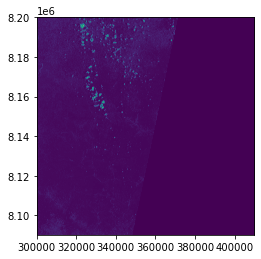

<AxesSubplot:>

In [81]:
src = rasterio.open("C:/Users/engelbert/Downloads/Ishango/Notebook/SentinelColor/SentinelTrueColor.tiff", count=3)
plot.show(src)

In [82]:
# export false color image

falseColor = rasterio.open('C:/Users/engelbert/Downloads/Ishango/Notebook/SentinelColor/SentinelFalseColor.tiff', 'w', driver='Gtiff',
                          width=band2.width, height=band2.height,
                          count=3,
                          crs=band2.crs,
                          transform=band2.transform,
                          dtype='uint16'                   
                         )
falseColor.write(band3.read(1),3) #Green
falseColor.write(band4.read(1),2) #Blue
#falseColor.write(band8.read(1),1) #nir
falseColor.close()

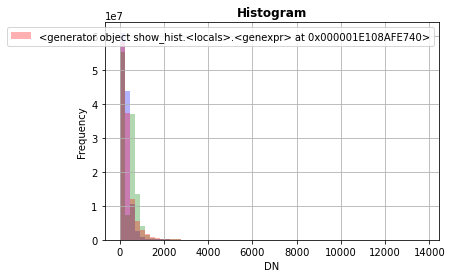

In [83]:
# generate histogram
trueColor = rasterio.open('C:/Users/engelbert/Downloads/Ishango/Notebook/SentinelColor/SentinelTrueColor.tiff')
plot.show_hist(trueColor, bins=60, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram");

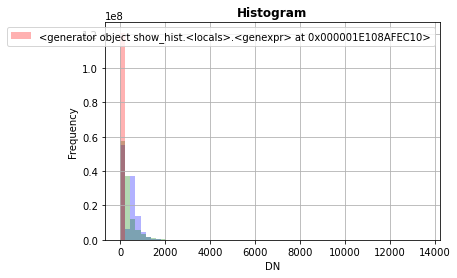

In [84]:
# generate histogram
trueColor = rasterio.open('C:/Users/engelbert/Downloads/Ishango/Notebook/SentinelColor/SentinelFalseColor.tiff')
plot.show_hist(trueColor, bins=60, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram");

# Clip Satellite images

One important preprocessing task to clip or mask an area of study. Since this RGB image is large and huge you save both computing power and time to clip and use only the area of interest. We will clip the shapefile from the RGB image.

In [86]:
"""
Here, we first reproject our shapefile with the same projection as the original image. 
Next, we open the RGB image, get the metadata and mask with the projected boundary.

The result is only the masked/clipped area of interest as shown in the above image.
"""


shapefile_Mozam_data1_proj = shapefile_Mozam_data1.to_crs({'init': 'epsg:32633'})

with rio.open("RGB.tiff") as src:
    #out_image, out_transform = rio.mask.mask(src, shapefile_data1_proj.geometry, crop=True)
    out_image, out_transform = msk.mask(src, shapefile_Mozam_data1_proj.geometry, invert=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rasterio.open("RGB_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

C:\Users\engelbert\.conda\envs\ishango_env\lib\site-packages\rasterio\mask.py:88: UserWarning: shapes are outside bounds of raster. Are they in different coordinate reference systems?
  warnings.warn('shapes are outside bounds of raster. '


### Check projection of Imagery and Shapefile in Python

In [87]:
# Check coordinate reference system (CRS) of both datasets
print('Shape file Projection: ', shapefile_Mozam_data1.crs)
print('-----------------------------------------')
print('|||||||||||||||||||| Little space |||||||')
print('-----------------------------------------')
print('Imagery file Projection: ', band4.crs)

Shape file Projection:  epsg:4326
-----------------------------------------
|||||||||||||||||||| Little space |||||||
-----------------------------------------
Imagery file Projection:  EPSG:32737


# Create NDVI (Normalized Difference Vegetation Index)

Calculating **NDVI** is an important indicator to assess the presence/absence of green vegetation from the satellite images. To calculate the **NDVI**, you need Red band and Near-Infrared Band **(NIR)**. Different satellite images assign different numbers for these bands. Sentinel Images have red in 4th band and **NIR** in the 8th band. The formula for **NDVI** calculation is:

$$ \mbox{NDVI} = \frac{\mbox{NIR} - \mbox{Red}}{\mbox{NIR} + \mbox{Red}}$$

To carry out this in Rasterio we need first to read the 4th and 8th bands as arrays. We also need to make sure that the arrays are floats.

In [88]:
# Open b4 and b8

path = 'C:/Users/engelbert/Downloads/Ishango/Notebook/S2A_MSIL2A_20210125T073201_N0214_R049_T37KCB_20210125T100129.SAFE/GRANULE/L2A_T37KCB_A029218_20210125T075032/IMG_DATA/R10m/'
band4 = rasterio.open(path+'T37KCB_20210125T073201_B04_10m.jp2')
band8 = rasterio.open(path+'T37KCB_20210125T073201_B08_10m.jp2')


# read Red(b4) and NIR(b8) as arrays
red = band4.read()
nir = band8.read()


# Calculate ndvi
ndvi = (nir.astype(float)-red.astype(float))/(nir+red)

# Write the NDVI image
meta = band4.meta
meta.update(driver='GTiff')
meta.update(dtype=rasterio.float32)

with rasterio.open('NDVI.tif', 'w', **meta) as dst:
    dst.write(ndvi.astype(rasterio.float32))

C:\Users\ENGELB~1\AppData\Local\Temp/ipykernel_10368/2934390558.py:14: RuntimeWarning: invalid value encountered in true_divide
  ndvi = (nir.astype(float)-red.astype(float))/(nir+red)


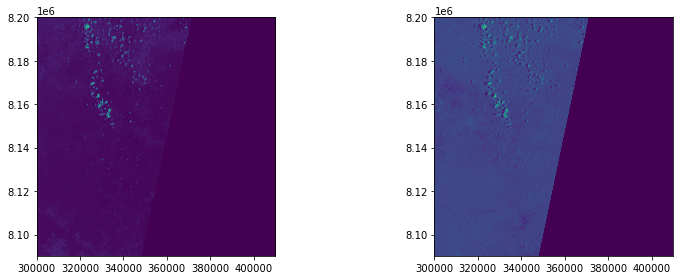

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot.show(band4, ax=ax1)
plot.show(band8, ax=ax2)
fig.tight_layout()

In [93]:
# tif = gdal.Open('C:/Users/engelbert/Downloads/Ishango/Notebook/RGB.tiff')

# band1 = tif.GetRasterBand(1)
# band2 = tif.GetRasterBand(2)
# band3 = tif.GetRasterBand(3)


# red = band1.ReadAsArray()
# green = band2.ReadAsArray()
# blue = band3.ReadAsArray()

# gray = (0.299*red + 0.587*green + 0.114*blue)

# plt.figure()
# plt.imshow(gray)
# plt.show()

In [94]:
# tif = gdal.Open('C:/Users/engelbert/Downloads/Ishango/Notebook/RGB_masked.tif')

# band1 = tif.GetRasterBand(1)
# band2 = tif.GetRasterBand(2)
# band3 = tif.GetRasterBand(3)


# red = band1.ReadAsArray()
# green = band2.ReadAsArray()
# blue = band3.ReadAsArray()

# # Affine transformation
# gray = (0.299*red + 0.587*green + 0.114*blue)

# plt.figure()
# plt.imshow(gray)
# plt.show()

### Visualize the NDVI file

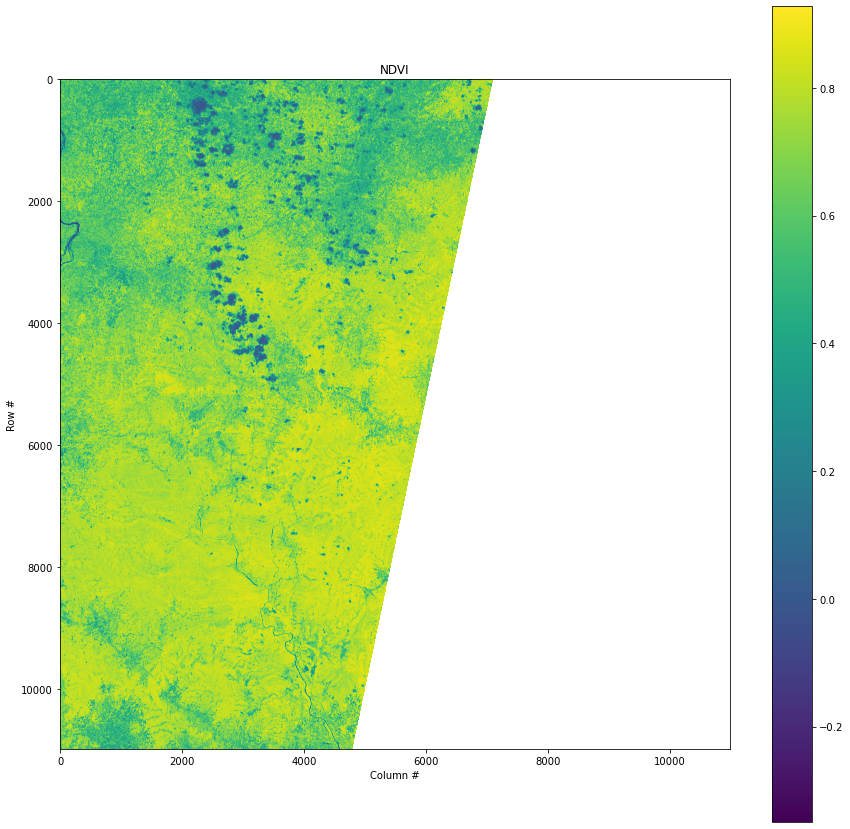

In [90]:
# Use MultiBandRaster() if image has multiple band
image = georaster.SingleBandRaster('C:/Users/engelbert/Downloads/Ishango/Notebook/NDVI.tif')

# The data of a SingleBandRaster is made available via image.r as a numpy array
# For MultiBandRaster(), image.r gives the raster in [height, width, band] format 
# band no. starts from 0

plt.figure(figsize = (15,15))
plt.imshow(image.r)  # or plt.imshow(image.r[:,:,])
plt.colorbar()
plt.title('NDVI')
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()

We can observe here a few pixels which is less than or equal to zero.

- The little high NDVI values indicate the presence of vegetation classes.
- The moderate NDVI and high values indicate stressed vegetation and healthy vegetation respectively.
- NDVI near to zero and negative values indicate non vegetation class such as water, snow, built-up areas and barren land. 

In [187]:
# path = 'C:/Users/engelbert/Downloads/Ishango/Notebook/NDVI.tif'

# with rasterio.open(path) as src:
#     print(src.profile)